In [ ]:
import tensorcircuit as tc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from scipy.optimize import least_squares
from noise_sim_tc import noise_sim
from scipy.optimize import curve_fit
from tensorcircuit.channels import amplitudedampingchannel

# 1. Test noise_sim

In [3]:

from tensorcircuit.channels import amplitudedampingchannel

# 从 txt 文件读取电路

qubit_num = 6 # 我们读取一个 6 qubit 的 Ising model 的演化电路. 

with open("openqasm_str.txt", "r", encoding="utf-8") as f:
    openqasm_str = f.read()

print("电路: ", openqasm_str)

# 转换为 tc 格式的电路并且输出
c_mat = tc.densitymatrix.DMCircuit.from_openqasm(openqasm_str)
print("noise-free circuit expectation:", c_mat.expectation_ps(z=[windex for windex in range(qubit_num)]))
c_mat.draw()

c_mat_noise = noise_sim(c_mat)
print("noiseless circuit expectation:", c_mat.expectation_ps(z=[windex for windex in range(qubit_num)]))
print("noisy circuit expectation:", c_mat_noise.expectation_ps(z=[windex for windex in range(qubit_num)]))

电路:  OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
h q[1];
cz q[0],q[1];
h q[1];
rz(-1.5707963267948966) q[1];
h q[1];
cz q[0],q[1];
h q[1];
h q[2];
cz q[1],q[2];
h q[2];
rz(-1.5707963267948966) q[2];
h q[2];
cz q[1],q[2];
h q[2];
h q[3];
cz q[2],q[3];
h q[3];
rz(-1.5707963267948966) q[3];
h q[3];
cz q[2],q[3];
h q[3];
h q[4];
cz q[3],q[4];
h q[4];
rz(-1.5707963267948966) q[4];
h q[4];
cz q[3],q[4];
h q[4];
h q[5];
cz q[4],q[5];
h q[5];
rz(-1.5707963267948966) q[5];
h q[5];
cz q[4],q[5];
h q[5];
h q[0];
cz q[5],q[0];
h q[0];
rz(-1.5707963267948966) q[0];
h q[0];
cz q[5],q[0];
h q[0];
rx(0.1) q[0];
rx(0.1) q[1];
rx(0.1) q[2];
rx(0.1) q[3];
rx(0.1) q[4];
rx(0.1) q[5];
h q[1];
cz q[0],q[1];
h q[1];
rz(-1.5707963267948966) q[1];
h q[1];
cz q[0],q[1];
h q[1];
h q[2];
cz q[1],q[2];
h q[2];
rz(-1.5707963267948966) q[2];
h q[2];
cz q[1],q[2];
h q[2];
h q[3];
cz q[2],q[3];
h q[3];
rz(-1.5707963267948966) q[3];
h q[3];
cz q[2],q[3];
h q[3];
h q[4];
cz q[3],q[4];
h q[4];
rz(-1.5707963267948966) 

In [4]:
c = tc.densitymatrix.DMCircuit(2)
c.x(1)
c.cz(0, 1)
c_noised_whole = noise_sim(c)
print("noiseless circuit expectation:", c.expectation_ps(z=[0,1]))
print("noisy whole circuit expectation:", c_noised_whole.expectation_ps(z=[0,1]))

noiseless circuit expectation: (-1+0j)
noisy whole circuit expectation: (-0.7968033+0j)


# 2. Functions

## 2.0. Noise Simulation

In [88]:
# 构建含噪声的电路和噪声电路的输出
def noise_sim(c_mat):
    """
    对于输入的电路中, 2 qubit gate 后面插入 noise. 
    c_mat: OpenQASM 字符串或者 tensorcircuit.densitymatrix.DMCircuit 对象

    """
    if isinstance(c_mat, str):
        # print("c_mat 是字符串")
        c_mat = tc.densitymatrix.DMCircuit.from_openqasm(c_mat)

    c_mat_qir = c_mat.to_qir()

    c_mat_noise = tc.densitymatrix.DMCircuit(c_mat._nqubits)
    for index in c_mat_qir:

        if len(index['index']) >= 2:

            # for jndex in index['index']:

            #     # 注意 noise 需要在 gate 前面加入才可以. # 这里加入 single qubit_noise
            #     c_mat_noise.depolarizing(jndex,px = 0.001, py = 0, pz = 0.001)

            # 这个地方可以加入任何我们想要加入的 noise, 下面试试能不能加入 2 qubit 的 noise 进去. 
            # cs = tc.channels.generaldepolarizingchannel(0.002,2)
            cs = tc.channels.generaldepolarizingchannel([1.68e-3,1.65e-3,1.2e-3,8.28e-4,3.53e-4,0,9.94e-4,1.06e-3,6.87e-5,0,8.53e-4,1.08e-3,1.26e-3,1.47e-3,0],2)
            c_mat_noise.apply_general_kraus(cs, [[index['index'][0], index['index'][1]]])

            c_mat_noise.append_from_qir([index])

        else:
            c_mat_noise.append_from_qir([index])

    return c_mat_noise

## 2.0. M inverse

In [89]:
# Define the size and labels for two-qubit Pauli operators (4x4=16)
pauli_labels = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

# Initialize the 16x16 matrix M with zeros
M = np.zeros((16, 16))

# Fill the matrix M based on Pauli commutation relations
for i in range(16):
    for j in range(16):
        # Decompose indices into qubit components (q1, q2)
        q1_i, q2_i = divmod(i, 4)  #q1_i为商，q2_i为余数 (q1_i, q2_i)_4为i的四进制表达
        q1_j, q2_j = divmod(j, 4)
        
        # 定义单量子比特 Pauli 矩阵
        pauli_matrix = [
            np.array([[1, 0], [0, 1]]),                  # I
            np.array([[0, 1], [1, 0]]),                  # X
            np.array([[0, -1j], [1j, 0]]),               # Y
            np.array([[1, 0], [0, -1]])                  # Z
        ]
        Pi = np.kron(pauli_matrix[q1_i], pauli_matrix[q2_i])  # Pi = P(q1_i) ⊗ P(q2_i)
        Pj = np.kron(pauli_matrix[q1_j], pauli_matrix[q2_j])  # Pj = P(q1_j) ⊗ P(q2_j)
        
        # Compute the commutation relations
        Pi_Pj = Pi @ Pj  
        Pj_Pi = Pj @ Pi

        M[i, j] = 0 if np.allclose(Pi_Pj, Pj_Pi) else 1

print(M)
try:
    # 尝试求逆矩阵
    M_inv = np.linalg.inv(M)
    print("Inverse matrix:\n", M_inv)
except np.linalg.LinAlgError:
    # 如果矩阵不可逆，就求伪逆
    M_inv = np.linalg.pinv(M)
    print("Pseudoinverse matrix:\n", M_inv)

# Print M_plus with row and column labels
print("Pseudoinverse matrix M_plus:")
print("       " + " ".join(f"{label:>6}" for label in pauli_labels))
for i, label in enumerate(pauli_labels):
    row_str = " ".join(f"{val:6.3f}" for val in M_inv[i])
    print(f"{label}: {row_str}")

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.]]
Pseudoinverse matrix:
 [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.125  0.125  0.125 -0.125 -0.125  0

## 2.1. Prepare initial states

In [90]:
def prepare_pauli_plus_state(c, qubit, idx):
    """
    在量子电路 c 的 qubit 位置制备对应 Pauli 的 +1 本征态
    idx: 0=I, 1=X, 2=Y, 3=Z
    """
    if idx == 0:  # I
        pass
    if idx == 1:  # X
        c.h(qubit)
    elif idx == 2:  # Y
        c.h(qubit)
        c.s(qubit)
    elif idx == 3:  # Z
        pass  

def prepare_pauli_word_plus_state(pauli_indices):
    """
    给定 Pauli word 的索引列表，例如 [0, 1, 2] = I⊗X⊗Y
    返回 TensorCircuit 对应制备电路
    """
    n = len(pauli_indices)
    c = tc.densitymatrix.DMCircuit(n)
    for qubit, idx in enumerate(pauli_indices):
        prepare_pauli_plus_state(c, qubit, idx)
    return c

# 示例：I ⊗ X ⊗ Y
pauli_indices = [0, 1, 2]
c = prepare_pauli_word_plus_state(pauli_indices)

print("Circuit:")
print(c)

# 得到状态向量
state = c.state()
print("\nStatevector:")
print(state)


Circuit:

Statevector:
[[0.24999997+0.j         0.        -0.24999997j 0.24999997+0.j
  0.        -0.24999997j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.24999997j 0.24999997+0.j         0.        +0.24999997j
  0.24999997+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.24999997+0.j         0.        -0.24999997j 0.24999997+0.j
  0.        -0.24999997j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.24999997j 0.24999997+0.j         0.        +0.24999997j
  0.24999997+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j       

## 2.2. Pauli words after Clifford conjugation

In [91]:
# 把Pauli word从Epsilon和U(CZ)中间挪到U（CZ)后

# 单比特 Pauli
I = np.array([[1,0],[0,1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
paulis = [I, X, Y, Z]
labels = ['I', 'X', 'Y', 'Z']

# CZ gate
CZ = np.diag([1,1,1,-1]).astype(complex)

def pauli_word(a, b):
    return np.kron(paulis[a], paulis[b])

# === 预计算映射表 ===
mapping = {}
for c, d in product(range(4), repeat=2):  # 遍历 Pm
    Pm = pauli_word(c, d)
    Pn_mat = CZ @ Pm @ CZ
    for a, b in product(range(4), repeat=2):  # 遍历 Pn
        Pw = pauli_word(a, b)
        if np.allclose(Pn_mat, Pw):
            mapping[(a, b)] = (c, d, +1)
        elif np.allclose(Pn_mat, -Pw):
            mapping[(a, b)] = (c, d, -1)

def find_m_for_given_n(a, b):
    """O(1) 查表"""
    return mapping.get((a, b))

# === 示例 ===
a, b = 3, 2  # n = X ⊗ Y
c, d, phase = find_m_for_given_n(a, b)
print(f"n = {labels[a]}⊗{labels[b]}, m = {labels[c]}⊗{labels[d]}, phase={phase}")
print("CZ0,1+ P_n CZ0,1 = Pm")
print(f"CZ0,1+ {labels[a]}⊗{labels[b]} CZ0,1 = {labels[c]}⊗{labels[d]}")
Pn=pauli_word(a, b)
Pm=pauli_word(c, d)
print(CZ @ Pn @ CZ == phase*Pm)


n = Z⊗Y, m = I⊗Y, phase=1
CZ0,1+ P_n CZ0,1 = Pm
CZ0,1+ Z⊗Y CZ0,1 = I⊗Y
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


## 2.3. Fidelity

In [92]:
# 不能用tc.Circuit(n, inputs=)具体的inputs应该通过|00...0>构造
# 不能用append
def cz_fidelity(observable, n_cz, isNoisy=True):
    """
    observable: list, e.g. [0,3]，0,1,2,3分别代表I,X,Y,Z，顺序对应比特0和1
    n_cz: int, CZ门数量
    返回有噪声电路的期望值
    """
    # 泡利算符映射
    pauli_keys = ['i', 'x', 'y', 'z']
    obs_dict = {pauli_keys[observable[0]]: [0], pauli_keys[observable[1]]: [1]}

    # 生成泡利算符列表
    pauli_dict = {
        'i': np.array([[1, 0], [0, 1]]),
        'x': np.array([[0, 1], [1, 0]]),
        'y': np.array([[0, -1j], [1j, 0]]),
        'z': np.array([[1, 0], [0, -1]])
    }
    # 生成泡利门列表
    pauli_gate_funcs = [lambda c, q: None,  # I门不操作
                lambda c, q: c.x(q),
                lambda c, q: c.y(q),
                lambda c, q: c.z(q)]
    

    # ================================================================================================
    # # （有 噪声前后的泡利算符），适用于将非pauli噪声转换成泡利噪声
    #     # CZ 门和带有噪声模拟的CZ门
    #     circuit_cz= tc.Circuit(2)
    #     circuit_cz.cz(0, 1)
    #     circuit_noise = noise_sim(circuit_cz)

    # # 构造电路
    # expectation_sum = 0
    # for i in range(4):
    #     for j in range(4):
    #         #已经定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    #         circuit = prepare_pauli_word_plus_state(observable) 
    #         # pauli算符(噪声门前)
    #         circuit_before_channel = tc.Circuit(2)
    #         pauli_gate_funcs[i](circuit_before_channel, 0)
    #         pauli_gate_funcs[j](circuit_before_channel, 1)
    #         # pauli算符(噪声门后)   
    #         circuit_after_channel = tc.Circuit(2)
    #         cz_i, cz_j, phase = find_m_for_given_n(i, j)
    #         pauli_gate_funcs[cz_i](circuit_after_channel, 0)
    #         pauli_gate_funcs[cz_j](circuit_after_channel, 1)
            
    #         # 构建电路
    #         for _ in range(n_cz):
    #             # 添加泡利算符(噪声前)
    #             circuit.append(circuit_before_channel)
    #             # 添加CZ门或者带有噪声模拟的CZ门
    #             if isNoisy:
    #                 circuit.append(circuit_noise)
    #             else:
    #                 circuit.append(circuit_cz)
    #             # 添加泡利算符(噪声后)
    #             circuit.append(circuit_after_channel)
                
    #         # 计算期望值
    #         expectation_sum+=circuit.expectation_ps(**obs_dict) 
    # return expectation_sum / (4**2) 
    

    # ================================================================================================
    # （无 噪声前后的泡利算符），适用noise channel本身就是pauli的情况
    # 构造电路
    # circuit = tc.densitymatrix.DMCircuit(2)
    c = prepare_pauli_word_plus_state(observable) #已经定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    for _ in range(n_cz):
        c.cz(0, 1)
    c = noise_sim(c) if isNoisy else c
    # 计算期望值
    expectation = c.expectation_ps(**obs_dict)
    return expectation

In [93]:
# noiseless fidelities(should all be 1)

f_noiseless=[]
for i in range(4):
    for j in range(4):
        fidelity2_ij = cz_fidelity([i,j], n_cz=2, isNoisy=False)
        fidelity4_ij = cz_fidelity([i,j], n_cz=4, isNoisy=False)
        if fidelity2_ij == 0:
            f_noiseless.append(0)
        else:
            f_noiseless.append(fidelity4_ij / fidelity2_ij)
print(f_noiseless)

[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]


In [94]:
# fidelities with noise
observable=[3,3]
result = cz_fidelity(observable, n_cz=2,isNoisy=False)
result_1 = cz_fidelity(observable, n_cz=2,isNoisy=True)
result_2 = cz_fidelity(observable, n_cz=4,isNoisy=True)
result_3 = cz_fidelity(observable, n_cz=20,isNoisy=True)
print(result, result_1, result_2, result_3)

(1+0j) (0.97424096+0j) (0.9491455+0j) (0.77030796+0j)


## 2.4. Fidelity Matrix

In [95]:
import numpy as np

def fidelity_matrix(k):
    """
    计算fidelity矩阵，fij_matrix[i,j] = fidelity_k+2_ij / fidelity_k_ij
    其中fidelity_k+2_ij表示作用k+2个含噪CZ门后保真度；fidelity_k_ij表示作用k个含噪CZ门后保真度
    其中i,j为泡利算符的索引，_4表示四进制，需要转换成十进制

    返回fij_matrix: (16, 16) array, 实部
    mask: (16, 16) bool array, True 表示该位置有观测
    """
    # Initialize storage
    fij_matrix = np.zeros((16, 16), dtype=float)  # 4x4 矩阵存储 fidelity4_ij / fidelity2_ij 的实部
    # fij_matrix的行代表(ij)_4,列代表(cz_i,cz_j)_4，_4表示四进制，需要转换成十进制
    # 列也就是U作用于Fij的结构（也是一个pauli word）的index
    mask = np.zeros((16, 16), dtype=bool)    # 初始元素都是False


    # Iterate over all Pauli observables [i,j]
    for i in range(4):
        for j in range(4):
            fidelity2_ij = cz_fidelity([i, j], n_cz=k, isNoisy=True)
            fidelity4_ij = cz_fidelity([i, j], n_cz=k+2, isNoisy=True)
            ratio = (fidelity4_ij / fidelity2_ij).real
            
            # 计算在 f_noisy 中的位置
            pos_row = i * 4 + j  
            cz_i, cz_j, phase = find_m_for_given_n(i, j)
            pos_col = cz_i * 4 + cz_j

            # U(Pa)=Pb，不能有相位差(phase=-1)
            if phase == 1:
                fij_matrix[pos_row, pos_col] = ratio
                mask[pos_row, pos_col] = True        # 填充矩阵

            # 处理特殊情况,第二个pauli word为X(j=1)等价于第二个pauli word为Z(j=3)
            if j == 3:
                j = 1
                pos_row = i * 4 + j  
                cz_i, cz_j, phase = find_m_for_given_n(i, j)
                pos_col = cz_i * 4 + cz_j
                fij_matrix[pos_row, pos_col] = ratio
                mask[pos_row, pos_col] = True        # 填充矩阵
            elif j == 1:
                j = 3
                pos_row = i * 4 + j  
                cz_i, cz_j, phase = find_m_for_given_n(i, j)
                pos_col = cz_i * 4 + cz_j
                fij_matrix[pos_row, pos_col] = ratio
                mask[pos_row, pos_col] = True        # 填充矩阵

    return np.real(fij_matrix), mask

## 2.5. Solve f(List) and w_k from fij(Matrix)

### 2.5.1. Without constraint

In [96]:
def solve_flist(fab_obs, mask):
    """
    输入:
      fab_obs: (n,m) array, 观测值（缺失位置可以任意）
      mask: bool array same shape, True 表示该位置有观测
    返回:
      fa (len n), fb (len m)
    备注:
      通过最小化残差 log(fab_ij) - (x_i + y_j) 来拟合 x,y，再 exp 得到 fa, fb。
      固定 x0 = 0 来去除平移自由度。
    """
    fab_obs = np.asarray(fab_obs, dtype=float)
    mask = np.asarray(mask, dtype=bool)
    if not np.all(fab_obs[mask] > 0):
        raise ValueError("Observed entries must be > 0 for log-linear method.")
    n, m = fab_obs.shape
    M = np.zeros_like(fab_obs)
    M[mask] = np.log(fab_obs[mask])

    # unknowns: x_rest (n-1) and y (m)
    def residuals(vars):
        x_rest = vars[:n-1]
        y = vars[n-1:]
        x = np.concatenate(([0.0], x_rest))
        # full predicted matrix in log-domain
        pred = x[:, None] + y[None, :]
        # return residuals only at observed entries
        return (pred - M)[mask].ravel()

    init = np.zeros((n-1) + m)
    sol = least_squares(residuals, init, method="trf")
    x_rest = sol.x[:n-1]
    y = sol.x[n-1:]
    x = np.concatenate(([0.0], x_rest))
    # fa=fb
    fa = np.exp(x)
    fb = np.exp(y)
    return fa

In [97]:
# ===== 测试 solve_flist =====
def test_solve_flist():
    np.random.seed(42)

    # 真实 fa, fb
    true_fa = np.array([1.2, 0.9, 1.5])
    true_fb = np.array([0.8, 1.1, 1.3, 0.95])

    # 构造 fab_true
    fab_true = np.outer(true_fa, true_fb)

    # 随机缺失
    mask = np.random.rand(*fab_true.shape) > 0.2  # 80% 概率保留
    # 噪声
    noise = np.random.normal(scale=0.02, size=fab_true.shape)
    fab_obs = fab_true * (1 + noise)

    # 调用求解
    fa_est = solve_flist(fab_obs, mask)

    # 归一化到与真实值同一比例（这里用 fa[0] 对齐）
    scale = true_fa[0] / fa_est[0]
    fa_est_scaled = fa_est * scale

    # 打印结果
    print("真实 fa:", true_fa)
    print("估计 fa:", np.round(fa_est_scaled, 4))
    print("缺失比例:", 1 - mask.mean())

# 运行测试
test_solve_flist()

真实 fa: [1.2 0.9 1.5]
估计 fa: [1.2    0.9017 1.4827]
缺失比例: 0.33333333333333337


### 2.5.2 With Constraint

In [98]:
import numpy as np

def solve_w_linear(fab_obs, mask, M_inv, *, eps=1e-12, ridge=1e-6, second_order=True, clip=(0.0, 1.0)):
    """
    无迭代（闭式/一次线性代数）解：
      1) 在线性方程 log(f_ij) ≈ x_i + y_j（仅mask位置）下求最小二乘（带岭正则）
      2) f_list = exp(x)
      3) λ = M_inv @ ( - log(f_list) / 2 )
      4) w ≈ 1 - λ (+ λ^2 如果 second_order=True)
      5) 将 w 裁剪到 clip 范围（默认 [0,1]，满足 w<=1 约束）

    参数
    ----
    fab_obs : (n,m) ndarray
        观测矩阵（缺失位置可任意值）
    mask : (n,m) bool ndarray
        True 表示该位置有观测
    M_inv : (n,n) ndarray
        给定的矩阵逆，用于 λ 计算
    eps : float
        防止 log(0) 的下限
    ridge : float
        岭正则系数，防稀疏/欠定
    second_order : bool
        True 使用二阶近似 w ≈ 1 - λ + λ^2；False 使用一阶 1 - λ
    clip : (low, high)
        输出 w 的裁剪范围，默认 (0,1)

    返回
    ----
    w : (n,) ndarray
    """
    fab_obs = np.asarray(fab_obs, dtype=float)
    mask = np.asarray(mask, dtype=bool)
    if np.count_nonzero(mask) == 0:
        raise ValueError("mask 全为 False，没有可用观测。")

    n, m = fab_obs.shape
    # 构造观测向量 b = log(f_ij)
    b = np.log(np.maximum(fab_obs[mask], eps))

    # 变量顺序：v = [x_1..x_{n-1}, y_0..y_{m-1}]，其中 x_0 固定为 0（消平移自由度）
    p = (n - 1) + m
    A = np.zeros((b.size, p), dtype=float)

    # 为每个观测 (i,j) 填行：x_i(若 i>0) + y_j
    idx = 0
    it = np.nditer(mask, flags=['multi_index'])
    for val in it:
        if val:
            i, j = it.multi_index
            # y_j 列索引
            A[idx, (n - 1) + j] = 1.0
            # x_i 列索引（跳过 i=0）
            if i > 0:
                A[idx, i - 1] = 1.0
            idx += 1

    # 岭正则 (A^T A + ridge I) v = A^T b
    AtA = A.T @ A
    Atb = A.T @ b
    if ridge > 0:
        AtA = AtA + ridge * np.eye(p)

    v = np.linalg.solve(AtA, Atb)

    # 还原 x, y，并得到 f_list = exp(x)
    x_rest = v[:(n - 1)]
    x = np.concatenate(([0.0], x_rest))  # x_0 = 0
    # y = v[(n - 1):]  # 如果你后续要用可取出

    f_list = np.exp(x)
    # λ = M_inv @ ( - log(f_list) / 2 )
    lam = M_inv @ ( - np.log(np.maximum(f_list, eps)) / 2.0 )

    # 小 λ 近似：w ≈ 1 - λ (+ λ^2)
    if second_order:
        w = 1.0 - lam + lam**2
    else:
        w = 1.0 - lam

    # 约束：w ∈ [clip_low, clip_high]，默认确保 w <= 1
    w = np.clip(w, clip[0], clip[1])
    return w


In [99]:
import numpy as np

def solve_w_exact(fab_obs, mask, M_inv, eps=1e-12, ridge=1e-6, clip=(0.0, 1.0)):
    """
    精确公式版：
      1) 最小二乘求 log(f_ij) ≈ x_i + y_j（仅mask位置）
      2) f_list = exp(x)
      3) λ = M_inv @ (-log(f_list)/2)
      4) w = (1 + exp(-2 λ)) / 2
      5) 裁剪 w 到 clip 范围

    参数
    ----
    fab_obs : (n,m) ndarray
        观测矩阵（缺失位置可任意值）
    mask : (n,m) bool ndarray
        True 表示该位置有观测
    M_inv : (n,n) ndarray
        给定矩阵逆
    eps : float
        防止 log(0)
    ridge : float
        岭正则系数
    clip : (low, high)
        输出 w 裁剪范围

    返回
    ----
    w : (n,) ndarray
    """
    fab_obs = np.asarray(fab_obs, dtype=float)
    mask = np.asarray(mask, dtype=bool)
    n, m = fab_obs.shape

    if np.count_nonzero(mask) == 0:
        raise ValueError("mask 全为 False，没有可用观测。")

    # 构造观测向量 b = log(f_ij)
    b = np.log(np.maximum(fab_obs[mask], eps))

    # 构造设计矩阵 A
    p = (n - 1) + m
    A = np.zeros((b.size, p), dtype=float)

    # 填充观测方程
    idx = 0
    it = np.nditer(mask, flags=['multi_index'])
    for val in it:
        if val:
            i, j = it.multi_index
            # y_j
            A[idx, (n - 1) + j] = 1.0
            # x_i (i>0)
            if i > 0:
                A[idx, i - 1] = 1.0
            idx += 1

    # 岭回归求解 v = [x_rest, y]
    AtA = A.T @ A + ridge * np.eye(p)
    Atb = A.T @ b
    v = np.linalg.solve(AtA, Atb)

    # 还原 x
    x_rest = v[:(n - 1)]
    x = np.concatenate(([0.0], x_rest))  # x0 = 0

    f_list = np.exp(x)
    lam = M_inv @ (-np.log(np.maximum(f_list, eps)) / 2.0)

    # 精确 w
    w = (1.0 + np.exp(-2.0 * lam)) / 2.0

    # 裁剪
    w = np.clip(w, clip[0], clip[1])
    return w


## 2.6. n-Layer Noise

In [100]:
def expectation_n_noisy_channel_cz(observable=[3,3], n_noise=1):
    # n_noise: int, 噪声channel层数,需要>=1，可以是小数
    n_noise_int = int(n_noise)
    n_noise_frac = n_noise - n_noise_int
    # observable = [3,3]默认输出zz基下的期望值
    
    # 泡利算符映射
    pauli_keys = ['i', 'x', 'y', 'z']
    obs_dict = {pauli_keys[observable[0]]: [0], pauli_keys[observable[1]]: [1]}
    
    # 生成泡利算符列表
    pauli_dict = {
        'i': np.array([[1, 0], [0, 1]]),
        'x': np.array([[0, 1], [1, 0]]),
        'y': np.array([[0, -1j], [1j, 0]]),
        'z': np.array([[1, 0], [0, -1]])
    }
    # 生成泡利门列表
    pauli_gate_funcs = [lambda c, q: None,  # I门不操作
                lambda c, q: c.x(q),
                lambda c, q: c.y(q),
                lambda c, q: c.z(q)]
    
    #定义c为2比特电路,初始态为observable对应的泡利算符的本征态
    c = prepare_pauli_word_plus_state(observable)
    # 在for循环后的cz门已经是带有噪声的了，所以如果不随即加入pauli word门，则噪声只作用于最后的cz门，相当于n_noise=1
    # 因此for循环的次数为n_noise-1
    
    if n_noise < 0 or 0 < n_noise < 1: #如果n_noise小于1
        raise ValueError('noised channel layer cannot be less than 1 (the gate itself is with error) or less than 0')
    # 处理小数次噪声
    if n_noise_frac > 1e-6: #如果小数部分大于1e-6
        for i in range(4):
            for j in range(4):
                n = 4*i+j
                rand = np.random.rand()
                if rand < n_noise_frac*(1-w[n]): #以n_noise_frac*(1-w[n])的概率施加pauli word门，表示噪声
                    pauli_gate_funcs[i](c, 0)
                    pauli_gate_funcs[j](c, 1)
    
    # 处理整数次噪声
    if n_noise_int >= 2: #如果整数部分大于等于2
        for _ in range(n_noise_int-1):
            for i in range(4):
                for j in range(4):
                    n = 4*i+j
                    rand = np.random.rand()
                    if rand < (1-w[n]): #以(1-w[n])的概率施加pauli word门，表示噪声
                        pauli_gate_funcs[i](c, 0)
                        pauli_gate_funcs[j](c, 1)
    
    # 添加 CZ 门
    c.cz(0, 1)
    # 添加噪声,虽然看起来对所有门（包括pauli words）都添加了噪声，但实际上噪声只作用于 CZ 门（因为噪声模拟器只作用于2比特门）
    if n_noise != 0:
        c = noise_sim(c) 
    # 计算期望值
    return np.real(c.expectation_ps(**obs_dict))

## 2.6. Plot Result

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def plot_zne_fit(x_values, y_values, figsize=(10, 6), 
                 title='Error Mitigation by Zero Noise Extrapolation (ZNE)',
                 xlabel='Number of Noisy Layer', ylabel='Expectation <Z01>',
                 xlim=(-0.5, 20.5), ylim=(-0.25, 1.2), xticks=[0, 4, 8, 12, 16, 20]):
    """
    Plot and fit data using exponential function for Zero Noise Extrapolation (ZNE).
    
    Parameters:
    - x_values: array-like, x data points
    - y_values: array-like, y data points
    - figsize: tuple, figure size
    - title: str, plot title
    - xlabel: str, x-axis label
    - ylabel: str, y-axis label
    - xlim: tuple, x-axis limits
    - ylim: tuple, y-axis limits
    - xticks: list, x-axis tick locations
    """
    # Set global style
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20
    plt.rcParams['mathtext.fontset'] = 'stix'

    # Define exponential function model
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c

    # Perform fitting
    popt, pcov = curve_fit(exp_func, x_values, y_values, p0=(1, -0.1, 0))
    x_fit = np.linspace(-0.5, max(x_values), 100)
    y_fit = exp_func(x_fit, *popt)

    # Calculate theoretical value
    theoretical_value = np.real(expectation_n_noisy_channel_cz(observable=[3,3], n_noise=0))

    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot elements
    plt.scatter(0, theoretical_value, color='red', s=100, 
               label='Theoretical expectation (no noise)')
    plt.scatter(0, exp_func(0, *popt), color='blue', s=100, 
               label='Fitted expectation (no noise)')
    plt.scatter(x_values, y_values, facecolors='none', edgecolors='blue', s=100, 
               label='Measured Data Points')
    plt.plot(x_fit, y_fit, 'b-', label="Exponential Fit", linewidth=2)

    # Set labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set axes limits and ticks
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(xticks)
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def plot_zne_fit_linear(x_values, y_values, figsize=(10, 6), 
                 title='Error Mitigation by Zero Noise Extrapolation (ZNE)',
                 xlabel='Number of Noisy Layer', ylabel='Expectation <Z01>',
                 xlim=(-0.5, 20.5), ylim=(-0.25, 1.2), xticks=[0, 4, 8, 12, 16, 20]):
    """
    Plot and fit data using exponential function for Zero Noise Extrapolation (ZNE).
    
    Parameters:
    - x_values: array-like, x data points
    - y_values: array-like, y data points
    - figsize: tuple, figure size
    - title: str, plot title
    - xlabel: str, x-axis label
    - ylabel: str, y-axis label
    - xlim: tuple, x-axis limits
    - ylim: tuple, y-axis limits
    - xticks: list, x-axis tick locations
    """
    # Set global style
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20
    plt.rcParams['mathtext.fontset'] = 'stix'

    # Define exponential function model
    def linear(x, a, b):
        return a*x + b

    # Perform fitting
    popt, pcov = curve_fit(linear, x_values, y_values, p0=(-0.1, 1))
    x_fit = np.linspace(-0.5, max(x_values), 100)
    y_fit = linear(x_fit, *popt)

    # Calculate theoretical value
    theoretical_value = np.real(expectation_n_noisy_channel_cz(observable=[3,3], n_noise=0))

    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot elements
    plt.scatter(0, theoretical_value, color='red', s=100, 
               label='Theoretical expectation (no noise)')
    plt.scatter(0, linear(0, *popt), color='blue', s=100, 
               label='Fitted expectation (no noise)')
    plt.scatter(x_values, y_values, facecolors='none', edgecolors='blue', s=100, 
               label='Measured Data Points')
    plt.plot(x_fit, y_fit, 'b-', label="Exponential Fit", linewidth=2)

    # Set labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set axes limits and ticks
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(xticks)
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# 3. Learn Noise of CZ gate

## 3.1. Get fidelity matrix

In [102]:
fij_2_matrix, mask = fidelity_matrix(2)
fij_4_matrix, mask = fidelity_matrix(4)
fij_6_matrix, mask = fidelity_matrix(6)
fij_8_matrix, mask = fidelity_matrix(8)
fij_10_matrix, mask = fidelity_matrix(10)
fij_matrix = (fij_2_matrix + fij_4_matrix + fij_6_matrix + fij_8_matrix + fij_10_matrix) / 5  # 取平均
print("Fidelity ratios (fij_list, real parts only):")
print(fij_matrix)
print("\nMissing entries (True if fidelity2_ij == 0):")
print(mask)

Fidelity ratios (fij_list, real parts only):
[[0.9999999  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.97424111 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.97528108 0.        ]
 [0.         0.         0.         0.97424111 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.97521909 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.97521909 0.


## 3.2. Get wk

### 3.2.1. Without constraint

In [103]:
f_list = solve_flist(fij_matrix, mask)
print(f_list)
lam = M_inv @ (-np.log(f_list)/2)
w = (1 + np.exp(-2 * lam)) / 2 
print(w)

[1.         0.98703653 0.9875632  0.98703653 0.98753182 0.98753182
 1.         0.98753182 0.98771422 0.98771422 0.98756315 0.98771422
 0.99168653 0.98703653 0.9875632  0.98703653]
[1.         0.99973209 0.99805325 0.99973209 0.9987323  1.00027203
 0.99868625 1.00027203 1.00022584 0.99868625 1.00027203 0.99868625
 0.99989567 0.99818611 0.99959881 0.99818611]


### 3.2.2. With constraint

In [116]:
# 假设已给出：fij_matrix (n,m), mask (n,m), M_inv (n,n)
w = solve_w_exact(fij_matrix, mask, M_inv)
print(w)

[1.         0.99973209 0.99805325 0.99973209 0.9987323  1.
 0.99868625 1.         1.         0.99868625 1.         0.99868625
 0.99989567 0.99818611 0.99959882 0.99818611]


## 3.2.3. w_k Plot

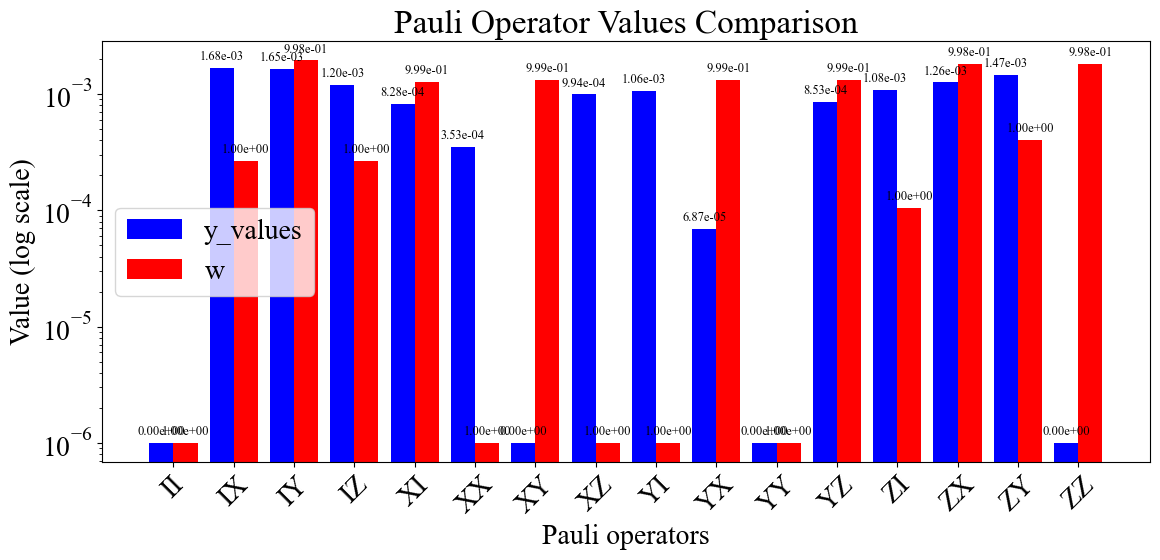

In [119]:
one_minus_w_input = [0, 1.68e-3,1.65e-3,1.2e-3,8.28e-4,3.53e-4,0,9.94e-4,1.06e-3,6.87e-5,0,8.53e-4,1.08e-3,1.26e-3,1.47e-3,0]
one_minus_w_output = [1 - w_k for w_k in w]

import matplotlib.pyplot as plt
import numpy as np

# 数据
x_values = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ',
            'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
y_values_1 = one_minus_w_input
y_values_2 = one_minus_w_output

# 替换0值以便对数显示
y_plot = [yi if yi > 0 else 1e-6 for yi in y_values_1]
w_plot = [wi if wi > 0 else 1e-6 for wi in y_values_2]

# 并排柱状图参数
x = np.arange(len(x_values))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, y_plot, width, label='y_values', color='blue')
bars2 = ax.bar(x + width/2, w_plot, width, label='w', color='red')

ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=45)
ax.set_ylabel('Value (log scale)')
ax.set_xlabel('Pauli operators')
ax.set_title('Pauli Operator Values Comparison')
ax.legend()

# 添加柱子标签
for bar, yi in zip(bars1, y_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height*1.1, f'{yi:.2e}',
            ha='center', va='bottom', fontsize=9)
for bar, wi in zip(bars2, w):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height*1.1, f'{wi:.2e}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 施加噪声n次

## 4.1. 整数层噪声 

In [141]:
simu_num = 500
expectation_n_noisy_channel_cz_list_int = []
n_noise_list_int = np.arange(1, 61, 3)  # 1到20整数步长

for n_noise in n_noise_list_int:
    expectation_avg = 0
    for _ in range(simu_num):
        expectation = expectation_n_noisy_channel_cz(n_noise=n_noise) 
        expectation_avg += expectation / simu_num
    expectation_n_noisy_channel_cz_list_int.append(expectation_avg)
    print(f"n={n_noise}, expectation={expectation_avg}")

n=1, expectation=0.9870365262031465
n=4, expectation=0.9317624807357711
n=7, expectation=0.9159698963165209
n=10, expectation=0.8567477047443329
n=13, expectation=0.7975255131721449
n=16, expectation=0.7856810748577073
n=19, expectation=0.746199613809582
n=22, expectation=0.7185625910758943
n=25, expectation=0.6948737144470191
n=28, expectation=0.6830292761325815
n=31, expectation=0.5882737696170807
n=34, expectation=0.5961700618267057
n=37, expectation=0.5566886007785804
n=40, expectation=0.6080145001411433
n=43, expectation=0.5527404546737679
n=46, expectation=0.5606367468833929
n=49, expectation=0.5132589936256425
n=52, expectation=0.41850348711013946
n=55, expectation=0.46982938647270384
n=58, expectation=0.45403680205345326


In [142]:
# 创建 DataFrame
df = pd.DataFrame({
    'n_noise': n_noise_list_int,
    'expectation_avg': expectation_n_noisy_channel_cz_list_int
})

# 保存成CSV（Excel能打开）
df.to_csv('expectation_n_noisy_channel_cz_list_int_small_noise.csv', index=False)

## 4.2. 非整数层噪声 

In [121]:
simu_num = 5000
expectation_n_noisy_channel_cz_list_frac = []
n_noise_list_frac = np.arange(1, 3.5, 0.5) 

for n_noise in n_noise_list_frac:
    expectation_avg = 0
    for _ in range(simu_num):
        expectation = expectation_n_noisy_channel_cz(n_noise=n_noise) 
        expectation_avg += expectation / simu_num
    expectation_n_noisy_channel_cz_list_frac.append(expectation_avg)
    print(f"n={n_noise}, expectation={expectation_avg}")

n=1.0, expectation=0.9870365262032162
n=1.5, expectation=0.9803246778250342
n=2.0, expectation=0.9732180148363708
n=2.5, expectation=0.9665061664581888
n=3.0, expectation=0.9570306158066376


In [122]:
# 创建 DataFrame
df = pd.DataFrame({
    'n_noise': n_noise_list_frac,
    'expectation_avg': expectation_n_noisy_channel_cz_list_frac
})

# 保存成CSV（Excel能打开）
df.to_csv('expectation_n_noisy_channel_cz_list_frac_small_noise.csv', index=False)

# 结果画图

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. 数据读取部分（在函数外部完成）
def load_data(file_path):
    """从CSV文件加载数据"""
    df = pd.read_csv(file_path)
    x_values = df['n_noise'].values
    y_values = df['expectation_avg'].values
    return x_values, y_values

## 整数层噪声

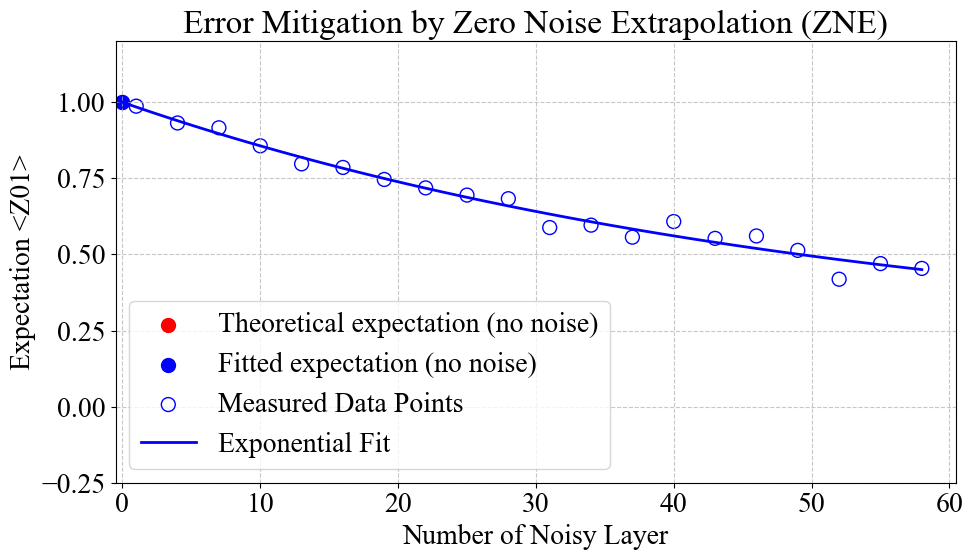

In [144]:
x_values, y_values = load_data('expectation_n_noisy_channel_cz_list_int_small_noise.csv')
plot_zne_fit(x_values, y_values,xticks=[0, 10, 20, 30, 40, 50, 60], xlim=(-0.5, 60.5))

## 非整数层噪声

[1.  1.5 2.  2.5 3. ] [0.98703653 0.98032468 0.97321801 0.96650617 0.95703062]


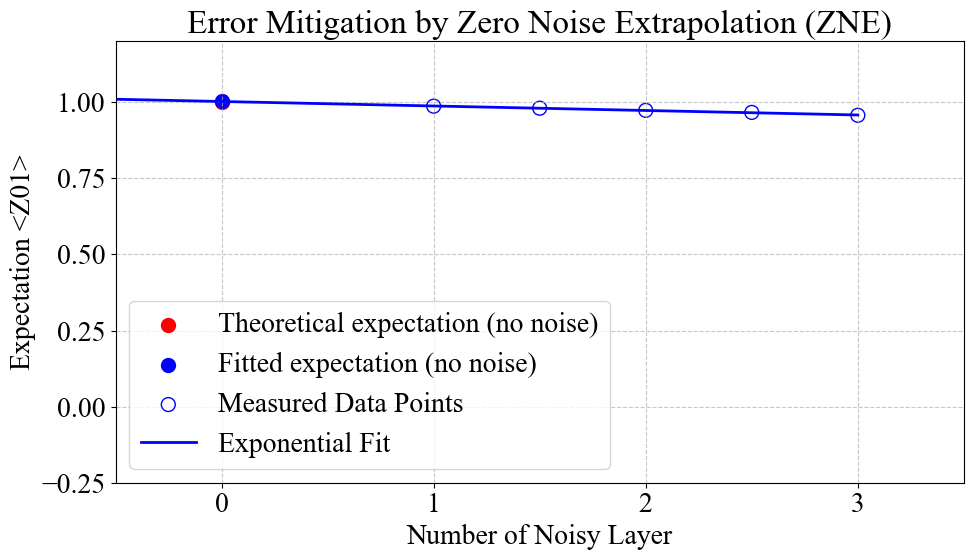

In [139]:
x_values, y_values = load_data('expectation_n_noisy_channel_cz_list_frac_small_noise.csv')
print(x_values, y_values)
plot_zne_fit_linear(x_values, y_values,xticks=[0,1,2,3],xlim=(-0.5,3.5))